In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import sys

from time import time

import multinet

import torch
import torchvision
from torchvision.transforms import Compose, ToTensor
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

from PIL import Image
import cropset

import matplotlib.pyplot as plt

In [35]:
net = multinet.pretrained("./model_multinet.pt")
backbone = net.features
# backbone.out_channels = net.classifier[1].in_features
backbone.out_channels = 20
num_classes = net.classifier[-1].out_features

anchor_generator = AnchorGenerator(
    sizes=((30, 40),), aspect_ratios=((0.5, 1.0, 2.0),))
    
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'], output_size=7, sampling_ratio=2)
    
model = FasterRCNN(
  backbone, num_classes=num_classes,
  rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

# pretrained convnet features but classifier is not taken from pretrained model

net, model

loaded module has 5 classes


(MultiNet(
   (features): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=3920, out_features=2600, bias=True)
     (2): ReLU(inplace=True)
     (3): Linear(in_features=2600, out_features=1000, bias=True)
     (4): ReLU(inplace=True)
     (5): Linear(in_features=1000, out_features=5, bias=True)
   )
 ),
 FasterRCNN(
   (transform): GeneralizedRCNNTransform(
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       Resize(min_size=(800,), max_size=1333, mode='bilinear')
   )
   (backbone): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=(1, 1

In [4]:
torch.__version__, torchvision.__version__

('1.9.0', '0.10.0')

In [4]:
dl = cropset.load(cropset.CropSet())
len(dl.dataset)

93

# class  0 should be background
# check if it converges

In [36]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=.005, momentum=0.9, weight_decay=0.0005)

STEP = 1

mlosses, maccs = [], []
for epoch in range(20):
  r_loss, r_acc = 0., 0.
  s = time()
  for i, (img, l) in enumerate(dl):
    model.train()
    loss_dict = model(img, l)
    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    r_loss += losses
    r_acc += 0  # dunno
    
    log = False
    if (i+1) % STEP == 0:
      divisor = 5
      log = True
    elif i+1 == len(dl):
      divisor = (i+1) % STEP
      log = True
    if log:
      mlosses.append(r_loss/divisor)
      maccs.append(r_acc/divisor)
      print(f"epoch:{epoch} loss:{mlosses[-1]:.4f} acc:{maccs[-1]:.2f} took:{time()-s:.2f}")
      s = time()
      r_loss, r_acc = 0., 0.


epoch:0 loss:0.4993 acc:0.00 took:3.44
epoch:0 loss:0.4945 acc:0.00 took:3.15
epoch:0 loss:0.4796 acc:0.00 took:3.09
epoch:0 loss:0.4712 acc:0.00 took:3.10
epoch:0 loss:0.4602 acc:0.00 took:2.92
epoch:0 loss:0.4529 acc:0.00 took:2.96
epoch:0 loss:0.4297 acc:0.00 took:3.02
epoch:0 loss:0.4188 acc:0.00 took:3.01
epoch:0 loss:0.4018 acc:0.00 took:3.19
epoch:0 loss:0.3751 acc:0.00 took:3.10
epoch:0 loss:0.3380 acc:0.00 took:3.17
epoch:0 loss:0.3077 acc:0.00 took:3.12
epoch:0 loss:0.2671 acc:0.00 took:3.25
epoch:0 loss:0.2215 acc:0.00 took:2.86
epoch:0 loss:0.2000 acc:0.00 took:3.18
epoch:0 loss:0.1913 acc:0.00 took:3.01
epoch:0 loss:0.1754 acc:0.00 took:3.42
epoch:0 loss:0.1978 acc:0.00 took:3.08
epoch:0 loss:0.2204 acc:0.00 took:2.97
epoch:0 loss:0.2085 acc:0.00 took:3.10
epoch:0 loss:0.2040 acc:0.00 took:3.02
epoch:0 loss:0.1963 acc:0.00 took:2.96
epoch:0 loss:0.2215 acc:0.00 took:2.95
epoch:0 loss:0.2011 acc:0.00 took:0.81
epoch:1 loss:0.1916 acc:0.00 took:2.99
epoch:1 loss:0.2293 acc:0

epoch:8 loss:0.0620 acc:0.00 took:2.83
epoch:8 loss:0.0727 acc:0.00 took:3.21
epoch:8 loss:0.0757 acc:0.00 took:2.80
epoch:8 loss:0.0794 acc:0.00 took:2.92
epoch:8 loss:0.0881 acc:0.00 took:952.34
epoch:9 loss:0.0683 acc:0.00 took:2.92
epoch:9 loss:0.0714 acc:0.00 took:3.85
epoch:9 loss:0.0877 acc:0.00 took:3.19
epoch:9 loss:0.0817 acc:0.00 took:2.79
epoch:9 loss:0.0667 acc:0.00 took:3.18
epoch:9 loss:0.0803 acc:0.00 took:3.09
epoch:9 loss:0.0947 acc:0.00 took:3.26
epoch:9 loss:0.0792 acc:0.00 took:2.86
epoch:9 loss:0.0687 acc:0.00 took:3.38
epoch:9 loss:0.0757 acc:0.00 took:3.32
epoch:9 loss:0.0645 acc:0.00 took:3.00
epoch:9 loss:0.0836 acc:0.00 took:3.14
epoch:9 loss:0.0678 acc:0.00 took:3.01
epoch:9 loss:0.0692 acc:0.00 took:3.07
epoch:9 loss:0.0774 acc:0.00 took:955.43
epoch:9 loss:0.0648 acc:0.00 took:2.91
epoch:9 loss:0.0608 acc:0.00 took:3.03
epoch:9 loss:0.0680 acc:0.00 took:3.02
epoch:9 loss:0.0816 acc:0.00 took:3.44
epoch:9 loss:0.0931 acc:0.00 took:3.09
epoch:9 loss:0.0607 a

KeyboardInterrupt: 

In [39]:
[i.detach().item() for i in mlosses]

[0.49928006529808044,
 0.494549423456192,
 0.47964149713516235,
 0.4712105393409729,
 0.46016988158226013,
 0.4529396891593933,
 0.42965149879455566,
 0.41883546113967896,
 0.4017798900604248,
 0.375133752822876,
 0.33803123235702515,
 0.3077206313610077,
 0.26714256405830383,
 0.22150889039039612,
 0.20001058280467987,
 0.1912766396999359,
 0.17539356648921967,
 0.1977965086698532,
 0.22035956382751465,
 0.2085486203432083,
 0.2040141075849533,
 0.1962718665599823,
 0.22147540748119354,
 0.2010916769504547,
 0.19161418080329895,
 0.22928151488304138,
 0.22531676292419434,
 0.20313644409179688,
 0.2545195519924164,
 0.20949527621269226,
 0.2303389608860016,
 0.24822063744068146,
 0.20854982733726501,
 0.273602694272995,
 0.21982863545417786,
 0.25990909337997437,
 0.22864535450935364,
 0.263144314289093,
 0.1996915638446808,
 0.21553464233875275,
 0.1919163167476654,
 0.19690823554992676,
 0.18092355132102966,
 0.19603204727172852,
 0.18757352232933044,
 0.2179161012172699,
 0.22321288

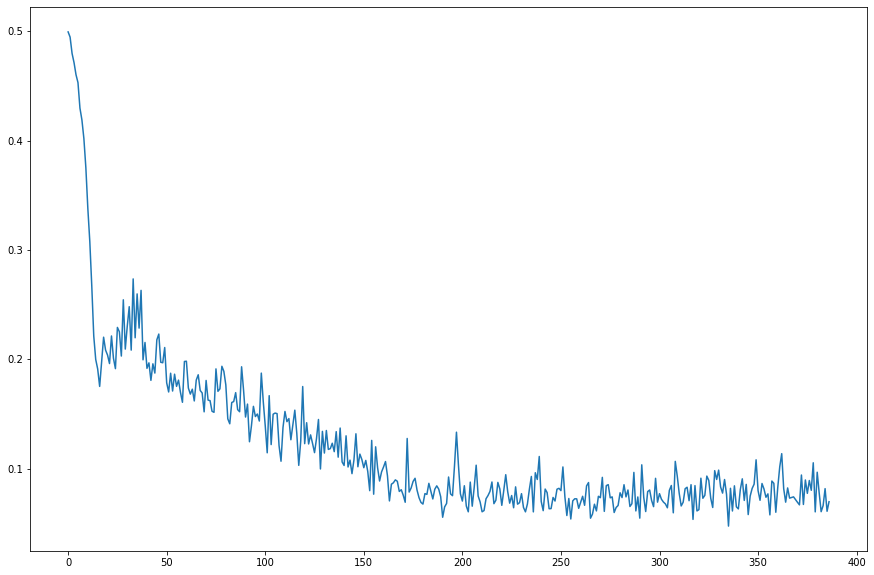

In [44]:
plt.figure(figsize=(15,10))
plt.plot([i.detach().item() for i in mlosses])
plt.show()

In [45]:
with torch.no_grad():
  transform = Compose([ToTensor()])
  img = transform(Image.open("/Users/lair/fun/waai/labelling/source/1882_1_6615.png").convert('RGB'))
  print(img.shape)
  model.eval()
  y = model(img.unsqueeze(0))
y

torch.Size([3, 640, 800])


[{'boxes': tensor([[ 5.6223, 18.7844, 33.8451, 58.4330],
          [ 4.7795, 19.5935, 30.6033, 54.5921],
          [37.1403, 10.5822, 61.9365, 45.3412],
          [35.0385, 10.6753, 63.4218, 49.7470]]),
  'labels': tensor([2, 3, 3, 2]),
  'scores': tensor([0.2461, 0.0767, 0.0552, 0.0540])}]

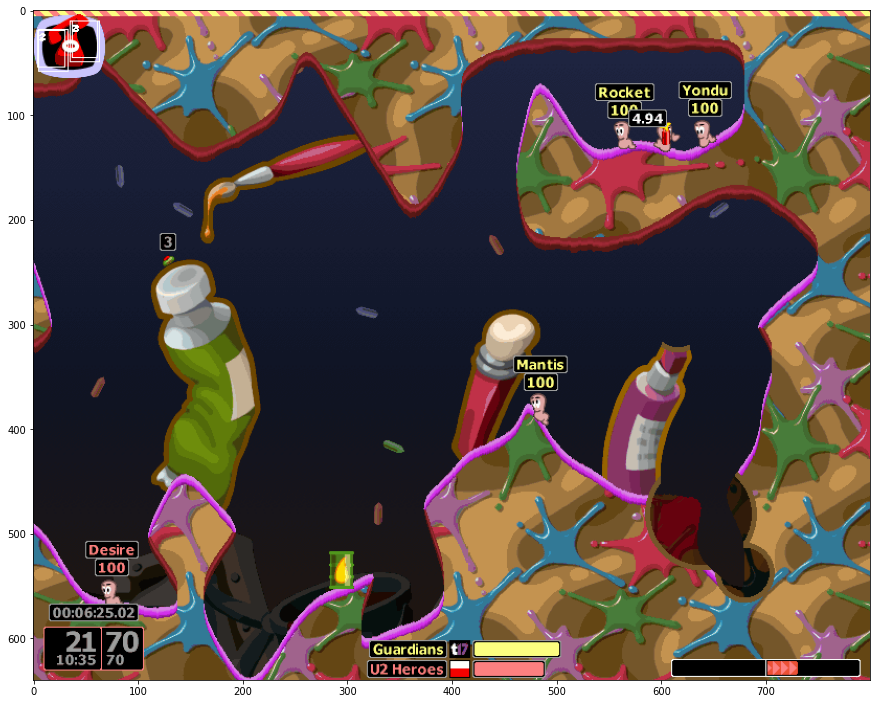

In [75]:
plt.figure(figsize=(15,15))
bb = draw_bounding_boxes((img*255).to(torch.uint8), boxes=y[0]['boxes'], labels=[str(i.item()) for i in y[0]['labels']])
plt.imshow(bb.permute(1,2,0))
plt.show()

In [7]:
models.detection.fasterrcnn_resnet50_fpn()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/lair/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [39]:
models.mobilenet_v2()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen